In [1]:
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid

from src.utils.dataset import dataset_to_dataloaders, show_class_name, get_class_example_image
from src.utils.visual import show_img, tensor_to_image, postprocess_image
from src.utils.training import fit, test_model
from src.models import get_model, HookedModel, load_model_weights_and_metrics
from src.deepdream import dream_process
from src.utils.config import RESNET18_FULL, RESNET18_TRANSFER, RESNET34_FULL, RESNET34_TRANSFER, RESNET50_FULL, RESNET50_TRANSFER, RESNET18_TEST
from src.utils.config import DREAM_CONFIG, BEETLE_DATASET, DEFAULT_TRAINING
from src.utils.config import get_new_config
from src.utils.custom_types import *


# Import configuration dictionaries
Things work a bit differently now. Below we import configuration dictionaries that define our model, dataset and training.

These dictionaries are defined inside `src/utils/config.py`.

In [2]:
dataset_config = BEETLE_DATASET
model_config = RESNET50_FULL
training_config = DEFAULT_TRAINING

# Set up device and workers

In [3]:
# start by setting up device
torch.cuda.empty_cache()

# Apply transforms and get dataloaders

dataset sizes: {'train': 8816, 'val': 2205, 'test': 2756}


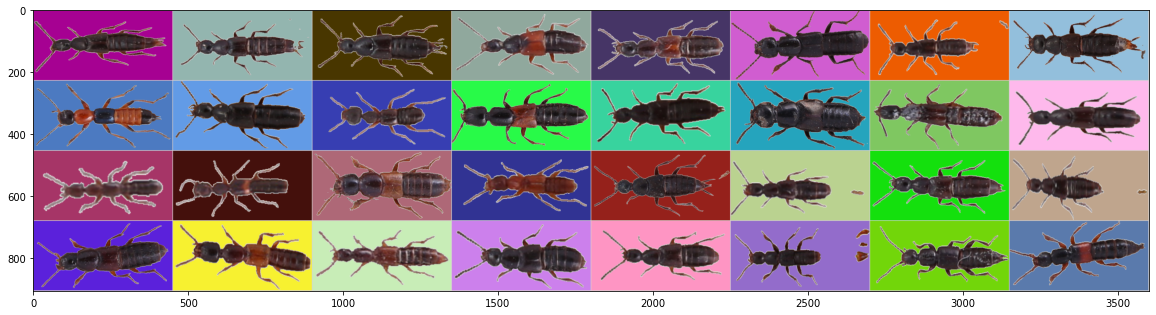

In [4]:
data_loaders, dataset_sizes = dataset_to_dataloaders(dataset_config)
iterable = iter(data_loaders['train'])
images, labels = next(iterable)
tensor_grid = make_grid(images, nrow=8)
image_grid = postprocess_image(tensor_to_image(tensor_grid))
show_img(image_grid, figsize=(20, 20))

# Define classification model

In [5]:
print('Loading {}'.format(model_config['model_architecture']))
model = get_model(model_config, dataset_config)

Loading resnet50


# Train and or load classification model

In [6]:
load = True
if load == True:
    metrics, model_config, dataset_config, training_config = load_model_weights_and_metrics(model, model_config)
    print(("test accuracy = %.2f %%" % training_config['train_info']['test_acc']))
else:
    metrics = fit(model, data_loaders, dataset_sizes,
                  model_config, training_config, dataset_config, 
                  clear='notebook', plot=True, save_interval=1)
    acc = test_model(model, data_loaders['test'], training_config, str(model_config['device']))
_ = model.eval()

test accuracy = 90.02 %


# Expose layers

In [7]:
dreamnet = HookedModel(model)
_ = dreamnet.eval()
dreamnet.show_modules()

[('', ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

# Lets dream!

## Choose image

You can see what a specific class's name is with the function below.

In [8]:
show_class_name(0, dataset_config)
a = [1]
b = tuple([1, 0])
print(type())

class 0: ./data/beetles/images/philonthus_cognatus


This one takes a class label and returns an image instead.

Class path/name: ./data/beetles/images/philonthus_cognatus


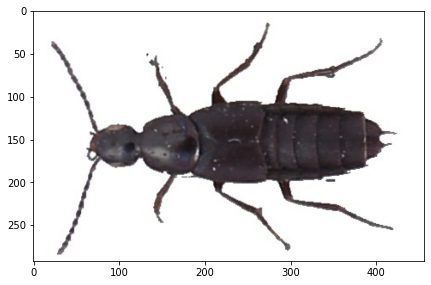

In [9]:
img = get_class_example_image(0, dataset_config)
show_img(img)

## Choose parameters and apply method

In [10]:
Path("figures").mkdir(parents=True, exist_ok=True)
Path("videos").mkdir(parents=True, exist_ok=True)

blob_path = 'blob.png'
blob_legs_path = 'complex_blob.png'

params: DreamConfig = {
    'input_img_path': None,#blob_legs_path,
    'out_info': {'fc': 150},
    'num_iters': 50,
    'levels': 3,
    'ratio':1.5,
    #'lr': 0.2,
    #'smooth_coef': 0,
    'noise': 'correlated_uniform',
    'target_shape': (200, 400),
    'show': False,
    'output_img_path' : 'figures/dreamt_image_correlated_uniform.jpg',
    'video_path': 'videos/dreamt_image_correlated_uniform.gif'
}
training_config = DEFAULT_TRAINING
dream_config: DreamConfig = get_new_config(params, DREAM_CONFIG)
output_images = dream_process(dreamnet, dream_config, model_config, dataset_config, training_config)

/home/pants007/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
